In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
import pickle

with open('resized_combined_dataset.pkl', 'rb') as f:
    datasets = pickle.load(f)

In [5]:
X = [img for img, label in datasets]
y = [label for img, label in datasets]

In [6]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Custom dataset for PIL images and labels
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

# Create dataset and dataloader
dataset = ImageDataset(X, y, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create datasets and dataloaders for train and validation
train_dataset = ImageDataset(X_train, y_train, transform=transform)
val_dataset = ImageDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

Epoch 1/5 - Train Loss: 0.6693 - Val Loss: 0.4476 - Val Acc: 0.7349
Epoch 2/5 - Train Loss: 0.2432 - Val Loss: 0.1655 - Val Acc: 0.9457
Epoch 3/5 - Train Loss: 0.0890 - Val Loss: 0.0504 - Val Acc: 0.9916
Epoch 4/5 - Train Loss: 0.0322 - Val Loss: 0.0355 - Val Acc: 0.9916
Epoch 5/5 - Train Loss: 0.0164 - Val Loss: 0.0110 - Val Acc: 0.9979


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       1.00      1.00      1.00       233

    accuracy                           1.00       479
   macro avg       1.00      1.00      1.00       479
weighted avg       1.00      1.00      1.00       479



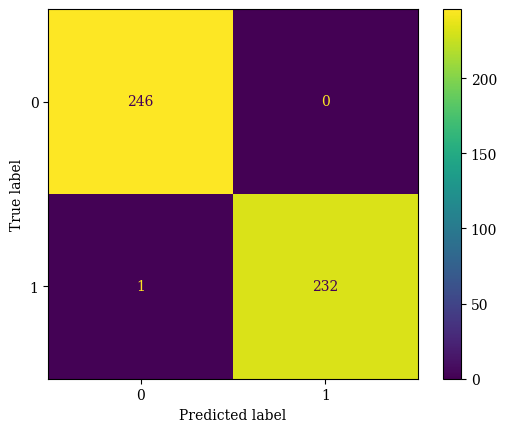

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'serif'

# Get predictions for the entire validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

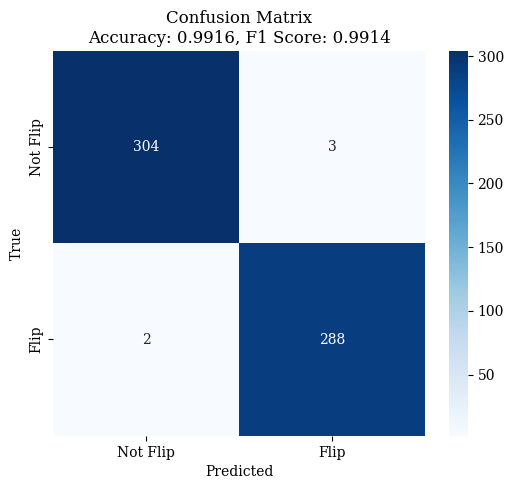

In [15]:
import os
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from random import shuffle

# Load test images and labels
test_flip_dir = os.path.join('images', 'testing', 'flip')
test_notflip_dir = os.path.join('images', 'testing', 'notflip')

test_flip_images = []
for filename in os.listdir(test_flip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(test_flip_dir, filename)
        img = Image.open(img_path)
        test_flip_images.append(img)

test_notflip_images = []
for filename in os.listdir(test_notflip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(test_notflip_dir, filename)
        img = Image.open(img_path)
        test_notflip_images.append(img)

# Create labeled test dataset
test_flip_dataset = [(img, 1) for img in test_flip_images]
test_notflip_dataset = [(img, 0) for img in test_notflip_images]
test_combined_dataset = test_flip_dataset + test_notflip_dataset
shuffle(test_combined_dataset)

X_test = [img for img, label in test_combined_dataset]
y_test = [label for img, label in test_combined_dataset]

# Create test dataset and dataloader
test_dataset = ImageDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Predict labels using trained model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy and F1 score
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flip', 'Flip'], yticklabels=['Not Flip', 'Flip'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix\nAccuracy: {acc:.4f}, F1 Score: {f1:.4f}')
plt.show()

In [16]:
# Visualize feature maps at the end of each CNN layer for a sample image

def visualize_feature_maps(model, image, device, suptitle):
    model.eval()
    image = transform(image).unsqueeze(0).to(device)

    # Forward pass and capture outputs after each conv layer
    with torch.no_grad():
        x = F.relu(model.conv1(image))
        x1 = model.pool(x)
        x2 = F.relu(model.conv2(x1))
        x2 = model.pool(x2)

    # Helper to plot feature maps
    def plot_feature_maps(feature_tensor, title, num_channels=8):
        plt.figure(figsize=(15, 2))
        for i in range(num_channels):
            plt.subplot(1, num_channels, i+1)
            plt.imshow(feature_tensor[0, i].cpu(), cmap='rainbow')
            plt.axis('off')
            plt.title(f'{title} {i+1}')
        plt.suptitle(suptitle)
        plt.tight_layout()
        plt.show()

    plot_feature_maps(x1, 'Conv1 Features')
    plot_feature_maps(x2, 'Conv2 Features')

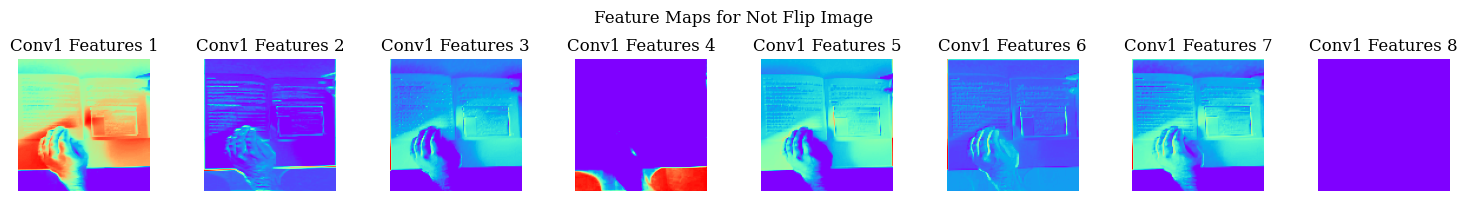

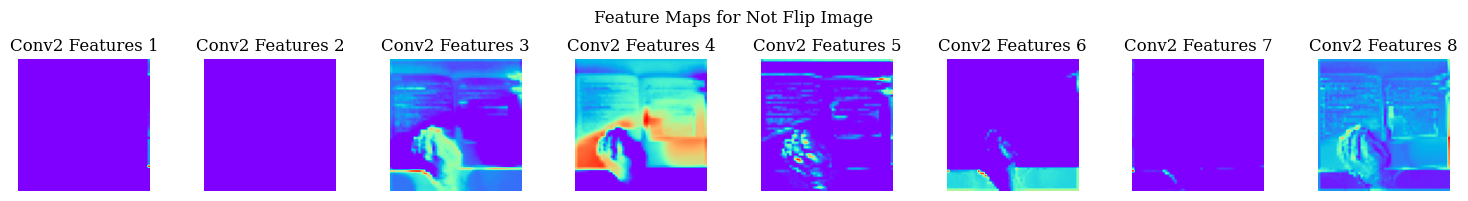

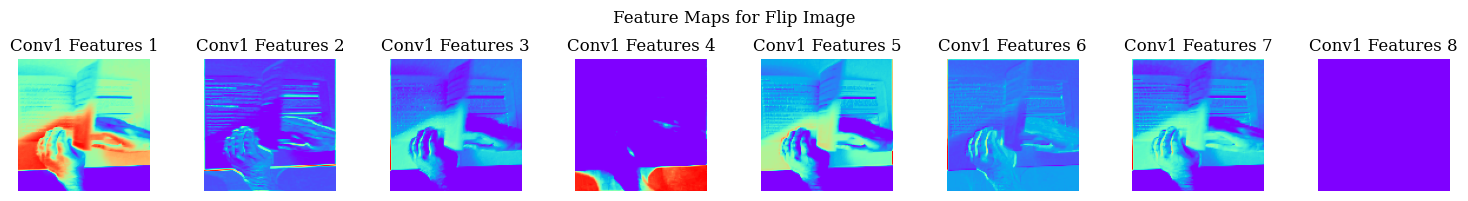

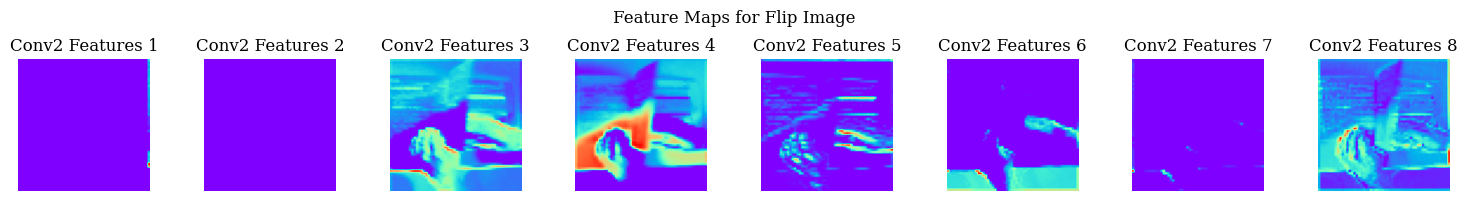

In [18]:
# Example: visualize features for a notflip image
visualize_feature_maps(model, test_notflip_images[0], device, 'Feature Maps for Not Flip Image')

# Example: visualize features for a flip image
visualize_feature_maps(model, test_flip_images[0], device, 'Feature Maps for Flip Image')